In [66]:
import os.path as osp
import sys

import matplotlib.pyplot as plt
import numpy as np
import omegaconf
import torch
import torch.linalg as tln

sys.path.insert(0, "../src")

from data_utils import PolynomialDataset
from lighting_utils import LitLinearNet
from pnml_utils import PnmlAnalytical
from torch.utils.data import DataLoader

In [67]:
def calc_net_effective_theta(net):
    for l, (name, param) in enumerate(net.named_parameters()):
        if l == 0:
            #             features = x_arr
            param_all = param.T
        else:
            #             features = linear_net.model.layers[l-1](features)
            param_all = param_all @ param.T

        param_prev = param
    return param_all

In [68]:
# Load paths
paths = [
    "../output/multirun_train_erm_20210412_194206/experimnet_name=train_erm,intermediate_sizes=[]",
    "../output/multirun_train_erm_20210412_194206/experimnet_name=train_erm,intermediate_sizes=[6]",
    "../output/multirun_train_erm_20210412_194206/experimnet_name=train_erm,intermediate_sizes=[6,6]",
    "../output/multirun_train_erm_20210412_194206/experimnet_name=train_erm,intermediate_sizes=[6,6,6,6]",
    "../output/multirun_train_erm_20210412_194206/experimnet_name=train_erm,intermediate_sizes=[6,6,6,6,6,6]",
]

experimnet_dicts = []
for path in paths:
    model_path = osp.join(path, "model.ckpt")
    cfg = omegaconf.OmegaConf.load(osp.join(path, ".hydra/config.yaml"))
    experimnet_dicts.append({"cfg": cfg, "path": path, "model_path": model_path})

In [78]:
thetas = []
for experimnet_dict in experimnet_dicts:
    cfg = experimnet_dict["cfg"]
    model_path = experimnet_dict["model_path"]

    # Testing set
    x_test = np.arange(cfg.x_test_min, cfg.x_test_max, cfg.dx_test)
    testset = PolynomialDataset(x_test, np.empty(len(x_test)), cfg.model_degree)

    testloader = DataLoader(
        testset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers
    )

    linear_net = LitLinearNet.load_from_checkpoint(model_path)
    layer_num = len([_ for l in linear_net.model.layers.named_children()])

    y_hat_list = []
    linear_net.eval()
    with torch.no_grad():
        for x, _ in testloader:
            y_hats = linear_net.model(x)
            y_hat_list.append(y_hats)

    y_hats = torch.vstack(y_hat_list)

    print(linear_net.model)
    experimnet_dict["y_hats"] = y_hats
    experimnet_dict["testloader"] = testloader
    experimnet_dict["layer_num"] = layer_num

    theta = calc_net_effective_theta(linear_net)

    thetas.append({"num_layers": len(linear_net.model.layers), "params": theta})

LinearNet(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=1, bias=False)
  )
)
LinearNet(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=6, bias=False)
    (1): Linear(in_features=6, out_features=1, bias=False)
  )
)
LinearNet(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=6, bias=False)
    (1): Linear(in_features=6, out_features=6, bias=False)
    (2): Linear(in_features=6, out_features=1, bias=False)
  )
)
LinearNet(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=6, bias=False)
    (1): Linear(in_features=6, out_features=6, bias=False)
    (2): Linear(in_features=6, out_features=6, bias=False)
    (3): Linear(in_features=6, out_features=6, bias=False)
    (4): Linear(in_features=6, out_features=1, bias=False)
  )
)
LinearNet(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=6, bias=False)
    (1): Linear(in_features=6, out_features=6, bias=False)
    (2): Linear(in_features=6, out

(-2.0, 2.0)

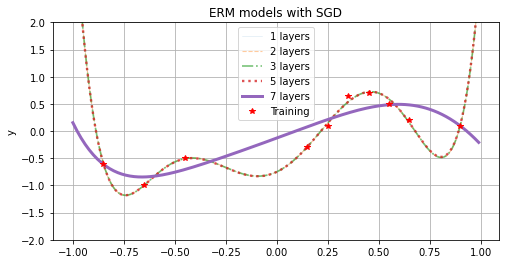

In [70]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(8, 4))
ax = axs

alphas = np.linspace(0.2, 1, len(experimnet_dicts))
ls = ["-", "--", "-.", ":"]
lw = np.linspace(0.5, 3, len(experimnet_dicts))

for i, experimnet_dict in enumerate(experimnet_dicts):
    cfg = experimnet_dict["cfg"]
    y_hats = experimnet_dict["y_hats"]
    testloader = experimnet_dict["testloader"]
    layer_num = experimnet_dict["layer_num"]
    ax.plot(
        testloader.dataset.x,
        y_hats,
        label=f"{layer_num} layers",
        alpha=alphas[i],
        linestyle=ls[i % len(ls)],
        linewidth=lw[i],
    )
ax.plot(cfg.x_train, cfg.y_train, "r*", label="Training")
ax.set_ylabel("y")
ax.set_title("ERM models with SGD")
ax.grid()
ax.legend()
ax.set_ylim(-2, 2)

In [81]:
# Training set
cfg = experimnet_dict["cfg"]
model_path = experimnet_dict["model_path"]

# Testing set
trainset = PolynomialDataset(cfg.x_train, cfg.y_train, cfg.model_degree)
x_arr = torch.tensor([x for x, _ in trainset])
x_arr.shape

torch.Size([10, 7])

In [88]:
for theta_dict in thetas:
    print(
        "num_layers={}. norm={}".format(
            theta_dict["num_layers"], tln.norm(theta_dict["params"], ord=np.inf)
        )
    )

num_layers=1. norm=32.917301177978516
num_layers=2. norm=32.96780014038086
num_layers=3. norm=32.96857833862305
num_layers=5. norm=32.88005447387695
num_layers=7. norm=1.3759171962738037
